In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from collections import defaultdict
import os.path as osp
from typing import Union, Dict, List
from itertools import combinations

from wilds.datasets.wilds_dataset import WILDSDataset

def get_eval_meta_args(logs, y_index, m_idx, split):
    num_batches = len(logs[f"{split}-metas"])
    logits_model = logs[f"{split}-logits"][m_idx]
    y_true = []
    y_pred= []
    metadata = []
    for batch_num in range(num_batches):
        curr_metadata= np.array(logs[f"{split}-metas"][batch_num])
        curr_y_true = curr_metadata[:,y_index]
        curr_logits = np.array(logits_model[batch_num])
        curr_y_pred = np.argmax(curr_logits, axis=1)

        y_true = y_true + curr_y_true.tolist()
        y_pred = y_pred + curr_y_pred.tolist()
        metadata = metadata + curr_metadata.tolist()
        

    y_true = torch.tensor(y_true)
    y_pred= torch.tensor(y_pred)
    metadata= torch.tensor(metadata)

    return y_pred, y_true, metadata

def get_results(filename_format, dataset:WILDSDataset, seeds:List[int], ensemble_size:int, meta_metrics:Union[List[str],None], inverse:bool, show_val:bool):
    y_index=dataset.metadata_fields.index("y")

    no_diversity=False
    res= defaultdict(list)
    
    for seed in seeds:
        filename= filename_format.format(seed=seed)
        filename = osp.join(filename,"summary.json")

        if not(osp.exists(filename)):
            continue

        with open(filename) as f:
            logs=json.load(f)

            res["test_acc_ensemble"].append(logs["ensemble-test-acc"])
            #res["best_single_model_test_acc"].append(max(logs["test-acc"]))

            for i in range(ensemble_size):
                res[f"test_m_{i+1}_acc"].append(logs["test-acc"][i])
                #res[f"val_m_{i+1}_acc"].append(logs[f"m{i+1}"]["valid-acc"][-1][1])

            pairwise_indexes = list(combinations(range(ensemble_size),2))
            test_sim = []
            unlabeled_sim = []
            for pairwise_idx in pairwise_indexes:
                i,j = pairwise_idx
                test_sim.append(logs["test_similarity"][i][j])
                unlabeled_sim.append(logs["unlabeled_final_similarty"][i][j])

            res["test_similarity"].append(np.array(test_sim).mean())
            res["unlabeled_final_similarity"].append(np.array(unlabeled_sim).mean())

            ## worst group eval
            for m_idx in range(ensemble_size):
                y_pred, y_true, test_metadata = get_eval_meta_args(logs=logs, y_index=y_index, m_idx=m_idx, split="test")
                eval_res = dataset.eval(y_pred=y_pred, y_true=y_true, metadata=test_metadata)
                for meta_metric in meta_metrics:
                    res[f"test_m_{m_idx+1}_{meta_metric}"].append(eval_res[0][meta_metric])

                if inverse:
                    eval_res = dataset.eval(y_pred=1-y_pred, y_true=y_true, metadata=test_metadata)
                    for meta_metric in meta_metrics:
                        res[f"test_m_{m_idx+1}_inverse_{meta_metric}"].append(eval_res[0][meta_metric])
                
                if "val-logits" in logs and show_val:
                    y_pred, y_true, val_metadata = get_eval_meta_args(logs=logs, y_index=y_index, m_idx=m_idx, split="val")
                    eval_res = dataset.eval(y_pred=y_pred, y_true=y_true, metadata=val_metadata)
                    for meta_metric in meta_metrics:
                        res[f"val_m_{m_idx+1}_{meta_metric}"].append(eval_res[0][meta_metric])

                    if inverse:
                        eval_res = dataset.eval(y_pred=1-y_pred, y_true=y_true, metadata=val_metadata)
                        for meta_metric in meta_metrics:
                            res[f"val_m_{m_idx+1}_inverse_{meta_metric}"].append(eval_res[0][meta_metric])

    
    return res

def display_results(filename_format:str,title:str, seeds:List[int], dataset:WILDSDataset, meta_metrics:Union[List[str],None]=None , ensemble_size=2 , inverse = False, show_val = False):

    res= get_results(filename_format=filename_format, dataset=dataset, meta_metrics=meta_metrics, seeds=seeds , ensemble_size=ensemble_size, inverse = inverse, show_val=show_val)
    df = pd.DataFrame(res)
    if df.empty:
        return
    results = df.aggregate(["mean","std"])

    print(title)
    pd.options.display.float_format = "{:,.3f}".format
    display(results)##inverse


In [5]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset


dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)

val_split_mask = dataset.split_array == dataset.split_dict["val"]
val_split_idx = np.where(val_split_mask)[0]

val_metadata_array = dataset.metadata_array[val_split_mask,:]

spurious = (val_metadata_array[:,0].numpy() == val_metadata_array[:,1].numpy())
spurious_val_split_idx = val_split_idx[spurious]
# little cheat to make the spurious val data points not attached to any split (train,val, test)
dataset.split_array[spurious_val_split_idx] = -1

len(spurious_val_split_idx)

NameError: name 'np' is not defined

## 64 HEADS EXPS WATERBIRDS CC

In [2]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_64_heads():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]


  
    waterbirds_filename_format= {
        "resnet18":"/datasets/home/hbenoit/D-BAT-exp/mult_heads/heads_64/waterbird/perturb=ood_is_test/['resnet18']_pretrained=False/ep[30]/ep=[30]_lrmax=0.001_alpha=0.1_dataset=waterbird_model=['resnet18']_pretrained=False_scheduler=none_seed=0_opt=sgd_ensemble_size=64_no_diversity=False"
    }

    for name, filename_format in waterbirds_filename_format.items():
        title = str.upper(name)
        res = get_results(filename_format=filename_format, dataset=dataset, meta_metrics=meta_metrics, seeds=[1], show_val=False,  ensemble_size=64 , inverse = False,)

display_64_heads()

: 

: 

In [2]:


import json
path = "/datasets/home/hbenoit/D-BAT-exp/mult_heads/heads_64/waterbird/perturb=ood_is_test/['resnet18']_pretrained=False/ep[30]/ep=[30]_lrmax=0.001_alpha=0.1_dataset=waterbird_model=['resnet18']_pretrained=False_scheduler=none_seed=1_opt=sgd_ensemble_size=64_no_diversity=False/summary.json"

with open(path,"r") as f:
    logs = json.load(f)


In [3]:
import torch

In [16]:
dataset.metadata_fields

['background', 'y', 'from_source_domain']

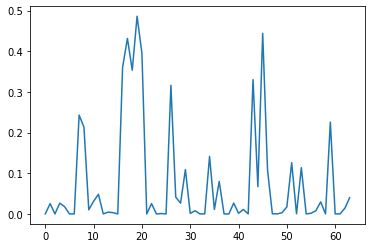

In [25]:


from wilds.datasets.waterbirds_dataset import WaterbirdsDataset
import numpy as np
import matplotlib.pyplot as plt

dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
y_index=dataset.metadata_fields.index("y")
y_index
meta_metrics=["acc_wg"]
split="test"
m_idx = 0
total_worst_acc=[]
total_worst_group=[]
total_avg_acc=[]
for m_idx in range(64):

    num_batches = len(logs[f"{split}-metas"])
    logits_model = logs[f"{split}-logits"][m_idx]
    y_true = []
    y_pred= []
    metadata = []
    for batch_num in range(num_batches):
        curr_metadata= np.array(logs[f"{split}-metas"][batch_num])
        curr_y_true = curr_metadata[:,y_index]
        curr_logits = np.array(logits_model[batch_num])
        curr_y_pred = np.argmax(curr_logits, axis=1)

        y_true = y_true + curr_y_true.tolist()
        y_pred = y_pred + curr_y_pred.tolist()
        metadata = metadata + curr_metadata.tolist()

    y_true = torch.tensor(y_true)
    y_pred= torch.tensor(y_pred)
    metadata= torch.tensor(metadata)

    groups_mask = {}

    for i in range(2):
        for j in range(2):
            background_mask = (metadata[:,dataset.metadata_fields.index("background")] == i)
            y_mask = (metadata[:,dataset.metadata_fields.index("y")] == j)

            groups_mask[(i,j)] = (torch.logical_and(background_mask, y_mask))

    res={}
    worst_group= (0,0)
    worst_acc = 1.1
    avg_acc = (y_pred == y_true).float().mean().item()

    for group, mask in groups_mask.items():
        res[group] = (y_pred[mask] == y_true[mask] ).float().mean().item()
        if worst_acc > res[group]:
            worst_acc = res[group]
            worst_group = group

    total_worst_acc.append(worst_acc)
    total_worst_group.append(worst_group)
    total_avg_acc.append(avg_acc)


plt.plot(total_worst_acc)

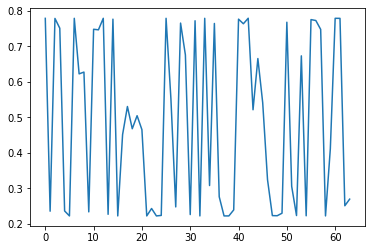

In [26]:
plt.plot(total_avg_acc)

In [18]:
groups_mask

{(0, 0): tensor([False, False, False,  ...,  True,  True, False]),
 (0, 1): tensor([False,  True, False,  ..., False, False, False]),
 (1, 0): tensor([False, False, False,  ..., False, False,  True]),
 (1, 1): tensor([ True, False,  True,  ..., False, False, False])}

In [13]:
metadata[:,dataset.metadata_fields["background"]]

TypeError: list indices must be integers or slices, not str

In [9]:
metadata[:,0] == 1

tensor([ True, False,  True,  ..., False, False,  True])

# Resnet_np and other arch on Waterbirds-CC-IC

In [3]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_ic_two_models_results():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    two_models_list = ["['resnet50_np', 'resnet50']", 
                        "['resnet50_np', 'vit_b_16']" ]            

    for alpha in [0.1]:
        for epoch in [30,60,100]:
            print(f"EPOCHS {epoch} alpha {alpha}")
            waterbirds_filename_format= {
                f"{two_models}": f"/datasets/home/hbenoit/D-BAT-exp/two_models_IC/waterbird/perturb=ood_is_test/{two_models}_pretrained=True/ep[{epoch}]/ep=[{epoch}]_lrmax=0.001_alpha={alpha}_dataset=waterbird_model={two_models}_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_inverse_corr"
                for two_models in two_models_list
            }

            for name, filename_format in waterbirds_filename_format.items():
                title = str.upper(name)
                display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], show_val=False)

display_all_waterbirds_cc_ic_two_models_results()

EPOCHS 30 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.743,0.572,0.861,0.647,0.088,0.063,0.688
std,0.007,0.045,0.034,0.042,0.006,0.066,0.033


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.765,0.572,0.852,0.648,0.062,0.063,0.668
std,0.008,0.045,0.033,0.038,0.015,0.066,0.015


EPOCHS 60 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.685,0.584,0.828,0.676,0.044,0.061,0.659
std,0.027,0.040,0.024,0.024,0.008,0.045,0.064


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.709,0.584,0.839,0.658,0.021,0.061,0.647
std,0.015,0.040,0.041,0.032,0.006,0.045,0.041


EPOCHS 100 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.661,0.582,0.837,0.670,0.029,0.064,0.680
std,0.022,0.026,0.014,0.010,0.011,0.035,0.030


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.687,0.582,0.844,0.660,0.011,0.064,0.670
std,0.014,0.026,0.017,0.017,0.006,0.035,0.006


# 3 models with resnet_np and resnet results

In [4]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_three_models_results():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    two_models_list = ["['resnet50_np', 'resnet50_np', 'resnet50']", 
                        "['resnet50_np', 'resnet50', 'resnet50']"]            

    alpha=0.1
    for epoch in [10,30,60]:
        print(f"EPOCHS {epoch} alpha {alpha}")
        waterbirds_filename_format= {
            f"{two_models}": f"/datasets/home/hbenoit/D-BAT-exp/three_models/waterbird/perturb=ood_is_test/{two_models}_pretrained=True/ep[{epoch}]/ep=[{epoch}]_lrmax=0.001_alpha={alpha}_dataset=waterbird_model={two_models}_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=3_no_diversity=False"
            for two_models in two_models_list
        }
        for name, filename_format in waterbirds_filename_format.items():
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, ensemble_size=3, seeds=[0,1,2], show_val=False)

display_all_waterbirds_cc_three_models_results()

EPOCHS 10 alpha 0.1
['RESNET50_NP', 'RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.647,0.567,0.616,0.844,0.723,0.680,0.102,0.079,0.610
std,0.044,0.036,0.067,0.008,0.025,0.023,0.068,0.071,0.161


['RESNET50_NP', 'RESNET50', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.724,0.567,0.837,0.725,0.761,0.704,0.102,0.569,0.256
std,0.010,0.036,0.015,0.025,0.008,0.017,0.068,0.159,0.044


EPOCHS 30 alpha 0.1
['RESNET50_NP', 'RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.638,0.562,0.609,0.783,0.664,0.402,0.067,0.080,0.664
std,0.054,0.012,0.112,0.026,0.024,0.040,0.013,0.062,0.115


['RESNET50_NP', 'RESNET50', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.710,0.562,0.804,0.689,0.704,0.358,0.067,0.716,0.341
std,0.005,0.012,0.015,0.015,0.029,0.012,0.013,0.086,0.027


EPOCHS 60 alpha 0.1
['RESNET50_NP', 'RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.626,0.564,0.541,0.815,0.649,0.342,0.086,0.157,0.718
std,0.025,0.027,0.071,0.032,0.020,0.005,0.051,0.089,0.046


['RESNET50_NP', 'RESNET50', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_m_3_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg,test_m_3_acc_wg
mean,0.706,0.564,0.763,0.694,0.677,0.336,0.086,0.699,0.389
std,0.009,0.027,0.074,0.004,0.014,0.001,0.051,0.114,0.008


# resnet_np + resnet tuning epochs results

In [3]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_two_models_results():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    two_models_list = ["['resnet50_np', 'resnet50']"]            

    for alpha in [0.1]:
        for first_epoch in [50,75,100]:
            for second_epoch in [10,20,30]:
                print(f"EPOCHS {[first_epoch,second_epoch]} alpha {alpha}")
                waterbirds_filename_format= {
                    f"{two_models}": f"/datasets/home/hbenoit/D-BAT-exp/two_models/waterbird/perturb=ood_is_test/{two_models}_pretrained=True/ep{[first_epoch,second_epoch]}/ep={[first_epoch,second_epoch]}_lrmax=0.001_alpha={alpha}_dataset=waterbird_model={two_models}_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False"
                    for two_models in two_models_list
                }

                for name, filename_format in waterbirds_filename_format.items():
                    title = str.upper(name)
                    display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], show_val=False)

display_all_waterbirds_cc_two_models_results()

EPOCHS [50, 10] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.664,0.566,0.855,0.659,0.555,0.065,0.709
std,0.016,0.016,0.020,0.022,0.019,0.019,0.021


EPOCHS [50, 20] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.709,0.566,0.804,0.594,0.134,0.065,0.719
std,0.031,0.016,0.020,0.029,0.041,0.019,0.072


EPOCHS [50, 30] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.742,0.566,0.817,0.574,0.086,0.065,0.765
std,0.022,0.016,0.016,0.021,0.046,0.019,0.009


EPOCHS [75, 10] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.622,0.557,0.866,0.631,0.520,0.080,0.687
std,0.007,0.011,0.021,0.027,0.022,0.030,0.059


EPOCHS [75, 20] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.653,0.557,0.814,0.589,0.082,0.080,0.740
std,0.029,0.011,0.014,0.019,0.021,0.030,0.043


EPOCHS [75, 30] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.659,0.557,0.798,0.588,0.060,0.080,0.711
std,0.022,0.011,0.010,0.037,0.043,0.030,0.023


EPOCHS [100, 10] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.608,0.568,0.829,0.677,0.555,0.071,0.656
std,0.019,0.023,0.032,0.032,0.032,0.013,0.034


EPOCHS [100, 20] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.655,0.568,0.812,0.568,0.074,0.071,0.749
std,0.019,0.023,0.013,0.056,0.042,0.013,0.037


EPOCHS [100, 30] alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.650,0.568,0.787,0.592,0.042,0.071,0.691
std,0.028,0.023,0.032,0.017,0.005,0.013,0.037


# resnet_np + other arch results

In [4]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_two_models_results():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    two_models_list = ["['resnet50_np', 'resnet50']", 
                        "['resnet50_np', 'vit_b_16']" ]            

    for alpha in ["1.0" ,0.1 ,0.001]:
        for epoch in [20,30,40]:
            print(f"EPOCHS {epoch} alpha {alpha}")
            waterbirds_filename_format= {
                f"{two_models}": f"/datasets/home/hbenoit/D-BAT-exp/two_models/waterbird/perturb=ood_is_test/{two_models}_pretrained=True/ep{epoch}/ep={epoch}_lrmax=0.001_alpha={alpha}_dataset=waterbird_model={two_models}_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False"
                for two_models in two_models_list
            }

            for name, filename_format in waterbirds_filename_format.items():
                title = str.upper(name)
                display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], show_val=False)

display_all_waterbirds_cc_two_models_results()

EPOCHS 20 alpha 1.0
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.811,0.574,0.704,0.403,0.030,0.057,0.523
std,0.017,0.061,0.102,0.047,0.011,0.041,0.157


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.800,0.574,0.836,0.586,0.022,0.057,0.670
std,0.029,0.061,0.045,0.028,0.006,0.041,0.044


EPOCHS 30 alpha 1.0
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.799,0.562,0.735,0.463,0.019,0.067,0.616
std,0.017,0.012,0.020,0.020,0.004,0.013,0.023


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.809,0.562,0.850,0.587,0.011,0.067,0.723
std,0.010,0.012,0.004,0.004,0.004,0.013,0.023


EPOCHS 40 alpha 1.0
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.787,0.548,0.758,0.491,0.015,0.088,0.671
std,0.023,0.017,0.025,0.034,0.008,0.039,0.068


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.785,0.548,0.830,0.600,0.013,0.088,0.631
std,0.044,0.017,0.057,0.047,0.003,0.039,0.137


EPOCHS 20 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.758,0.574,0.807,0.574,0.178,0.057,0.729
std,0.049,0.061,0.033,0.031,0.024,0.041,0.066


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.762,0.574,0.826,0.605,0.169,0.057,0.668
std,0.022,0.061,0.059,0.031,0.043,0.041,0.116


EPOCHS 30 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.758,0.562,0.804,0.583,0.103,0.067,0.716
std,0.035,0.012,0.015,0.047,0.051,0.013,0.086


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.787,0.562,0.842,0.599,0.081,0.067,0.746
std,0.011,0.012,0.010,0.012,0.005,0.013,0.012


EPOCHS 40 alpha 0.1
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.767,0.548,0.811,0.550,0.060,0.088,0.767
std,0.014,0.017,0.001,0.029,0.025,0.039,0.030


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.788,0.548,0.850,0.589,0.073,0.088,0.727
std,0.015,0.017,0.007,0.009,0.010,0.039,0.037


EPOCHS 20 alpha 0.001
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.651,0.574,0.718,0.789,0.795,0.057,0.212
std,0.029,0.061,0.005,0.007,0.008,0.041,0.004


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.628,0.574,0.681,0.796,0.795,0.057,0.369
std,0.017,0.061,0.011,0.019,0.030,0.041,0.027


EPOCHS 30 alpha 0.001
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.647,0.562,0.722,0.793,0.797,0.067,0.231
std,0.010,0.012,0.003,0.006,0.017,0.013,0.006


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.631,0.562,0.698,0.802,0.807,0.067,0.402
std,0.009,0.012,0.002,0.003,0.008,0.013,0.006


EPOCHS 40 alpha 0.001
['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.637,0.548,0.722,0.783,0.788,0.088,0.251
std,0.009,0.017,0.009,0.021,0.018,0.039,0.008


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.634,0.549,0.723,0.775,0.773,0.084,0.430
std,nan,nan,nan,nan,nan,nan,nan


# two arch results

In [6]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_two_models_results():
    
    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    two_models_list = ["['resnet50', 'vit_b_16']","['vit_b_16', 'resnet50']", "['resnet50_np', 'resnet50']", "['resnet50', 'resnet50_np']",
                        "['resnet50_np', 'vit_b_16']", "['vit_b_16', 'resnet50_np']", "['resnet50', 'resnet50MocoV2']", "['resnet50MocoV2', 'resnet50']" ]            

    for epoch in [10,30,100]:
        print(f"EPOCHS {epoch}")
        waterbirds_filename_format= {
            f"{two_models}": f"/datasets/home/hbenoit/D-BAT-exp/two_models/waterbird/perturb=ood_is_test/{two_models}_pretrained=True/ep{epoch}/ep={epoch}_lrmax=0.001_alpha=0.1_dataset=waterbird_model={two_models}_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False"
            for two_models in two_models_list
        }

        for name, filename_format in waterbirds_filename_format.items():
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0])

display_all_waterbirds_cc_two_models_results()

EPOCHS 10
['RESNET50', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.706,0.647,0.821,0.754,0.515,0.301,0.617
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.745,0.668,0.843,0.756,0.640,0.324,0.503
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.718,0.608,0.821,0.672,0.582,0.030,0.649
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.625,0.647,0.609,0.796,0.798,0.301,0.036
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.687,0.608,0.777,0.640,0.426,0.030,0.545
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.651,0.668,0.626,0.765,0.772,0.324,0.028
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50MOCOV2']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.697,0.647,0.788,0.773,0.740,0.301,0.062
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50MOCOV2', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.768,0.629,0.856,0.744,0.665,0.125,0.528
std,nan,nan,nan,nan,nan,nan,nan


EPOCHS 30
['RESNET50', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.771,0.649,0.815,0.692,0.020,0.308,0.671
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.750,0.663,0.748,0.650,0.036,0.327,0.673
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.794,0.560,0.808,0.545,0.072,0.067,0.771
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.667,0.649,0.704,0.703,0.690,0.308,0.026
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.800,0.560,0.841,0.599,0.085,0.067,0.751
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.658,0.663,0.677,0.734,0.716,0.327,0.036
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50MOCOV2']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.770,0.649,0.846,0.735,0.537,0.308,0.364
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50MOCOV2', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.767,0.691,0.720,0.658,0.057,0.276,0.613
std,nan,nan,nan,nan,nan,nan,nan


EPOCHS 100
['RESNET50', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.770,0.653,0.801,0.701,0.009,0.316,0.603
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.720,0.661,0.684,0.664,0.025,0.327,0.523
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.641,0.567,0.712,0.574,0.030,0.073,0.579
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.660,0.653,0.581,0.674,0.305,0.316,0.302
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50_NP', 'VIT_B_16']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.647,0.567,0.744,0.668,0.018,0.073,0.433
std,nan,nan,nan,nan,nan,nan,nan


['VIT_B_16', 'RESNET50_NP']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.683,0.661,0.696,0.685,0.529,0.327,0.083
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50', 'RESNET50MOCOV2']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.785,0.653,0.855,0.730,0.422,0.316,0.445
std,nan,nan,nan,nan,nan,nan,nan


['RESNET50MOCOV2', 'RESNET50']


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.703,0.712,0.625,0.661,0.032,0.280,0.377
std,nan,nan,nan,nan,nan,nan,nan


## WATERBIRDS RESULTS

In [2]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_results():

    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]            
    print("EPOCH 300, ALPHA 0.0001")
    waterbirds_filename_format= {
        "d_bat": "/datasets/home/liang/D-BAT-exp/results_reproduction1/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep300/ep=300_lrmax=0.001_alpha=0.0001_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
        "np_d_bat": "/datasets/home/liang/D-BAT-exp/results_reproduction1/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep300/ep=300_lrmax=0.001_alpha=0.0001_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    }

    #"np_erm": "/datasets/home/liang/D-BAT-exp/results_reproduction1/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep300/ep=300_lrmax=0.001_alpha=0.0_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=True_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    #"erm": "/datasets/home/liang/D-BAT-exp/results_reproduction1/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep300/ep=300_lrmax=0.001_alpha=0.0_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=True_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",

    for name, filename_format in waterbirds_filename_format.items():
        title = str.upper(name)
        display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2])

    for epoch in [30, 100,300]:
        print(f"EPOCH {epoch}, alpha 0.1\n")        
        waterbirds_filename_format= {
            "d_bat": f"/datasets/home/hbenoit/D-BAT-exp/alpha=0.1_train/results_reproduction2/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep{epoch}/ep={epoch}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
            "np_d_bat": f"/datasets/home/hbenoit/D-BAT-exp/alpha=0.1_train/results_reproduction2/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep{epoch}/ep={epoch}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
        }

        for name, filename_format in waterbirds_filename_format.items():
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2])


display_all_waterbirds_results()


EPOCH 300, ALPHA 0.0001
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.876,0.863,0.885,0.954,0.943,0.657,0.591
std,0.002,0.005,0.005,0.009,0.014,0.015,0.016


NP_D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.629,0.625,0.632,0.864,0.855,0.100,0.082
std,0.013,0.017,0.010,0.003,0.003,0.020,0.014


EPOCH 30, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.820,0.855,0.728,0.797,0.039,0.648,0.523
std,0.009,0.006,0.023,0.016,0.008,0.002,0.063


NP_D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.623,0.645,0.613,0.790,0.784,0.050,0.096
std,0.028,0.073,0.047,0.027,0.022,0.055,0.064


EPOCH 100, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.816,0.857,0.686,0.749,0.017,0.644,0.477
std,0.012,0.005,0.034,0.031,0.005,0.035,0.050


NP_D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.609,0.566,0.657,0.704,0.225,0.193,0.194
std,0.015,0.019,0.004,0.011,0.042,0.035,0.009


EPOCH 300, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.812,0.863,0.672,0.736,0.013,0.657,0.452
std,0.011,0.005,0.049,0.052,0.002,0.015,0.070


NP_D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.640,0.620,0.641,0.735,0.166,0.103,0.253
std,0.004,0.014,0.009,0.049,0.102,0.025,0.030


# WATERBIRDS_CC RESULTS

In [3]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_results():

    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    ##alpha=0.0001
    print("EPOCH 300, ALPHA 0.0001")
    waterbirds_filename_format= {
        "d_bat": "/datasets/home/liang/D-BAT-exp/results_reproduction_waterbird_cc/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep300/ep=300_lrmax=0.001_alpha=0.0001_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
        "d_bat_np": "/datasets/home/liang/D-BAT-exp/results_reproduction_waterbird_cc/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep300/ep=300_lrmax=0.001_alpha=0.0001_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
    }

    for name, filename_format in waterbirds_filename_format.items():
        title = str.upper(name)
        display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2])


    for epoch in [30,100,300]:
        print(f"EPOCH {epoch}, alpha 0.1\n")        
        waterbirds_filename_format= {
            f"d_bat": f"/datasets/home/hbenoit/D-BAT-exp/alpha=0.1_train/results_reproduction2/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep{epoch}/ep={epoch}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            f"d_bat_np": f"/datasets/home/hbenoit/D-BAT-exp/alpha=0.1_train/results_reproduction2/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep{epoch}/ep={epoch}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
        }

        for name, filename_format in waterbirds_filename_format.items():
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2])


display_all_waterbirds_cc_results()

EPOCH 300, ALPHA 0.0001
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.681,0.648,0.720,0.892,0.901,0.289,0.248
std,0.006,0.008,0.007,0.013,0.018,0.026,0.008


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.582,0.562,0.611,0.883,0.890,0.070,0.026
std,0.009,0.010,0.024,0.031,0.046,0.006,0.010


EPOCH 30, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.755,0.649,0.784,0.722,0.084,0.301,0.677
std,0.011,0.009,0.012,0.027,0.055,0.023,0.032


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.543,0.521,0.610,0.778,0.743,0.108,0.112
std,0.020,0.015,0.111,0.165,0.156,0.006,0.083


EPOCH 100, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.752,0.650,0.732,0.686,0.029,0.298,0.627
std,0.008,0.001,0.014,0.029,0.005,0.006,0.011


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.627,0.566,0.709,0.693,0.506,0.075,0.094
std,0.045,0.014,0.044,0.050,0.078,0.018,0.050


EPOCH 300, alpha 0.1

D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.761,0.648,0.742,0.672,0.029,0.289,0.656
std,0.021,0.008,0.005,0.051,0.008,0.025,0.060


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.596,0.560,0.665,0.743,0.231,0.064,0.150
std,0.019,0.005,0.039,0.032,0.070,0.004,0.051


# WATERBIRDS_CC_IC results


In [4]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_ic_results():

    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    ##alpha=0.0001
    for alpha in ["0.1", "1.0"] :
        for epochs in [30,100,300]:
            print(f"EPOCH {epochs} , ALPHA {alpha}")
            waterbirds_filename_format= {
                "d_bat": f"/datasets/home/hbenoit/D-BAT-exp/inverse_correlated/waterbird/perturb=ood_is_test/resnet50_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha={alpha}_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True_inverse_corr=True",
                "d_bat_np": f"/datasets/home/hbenoit/D-BAT-exp/inverse_correlated/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep{epochs}/ep={epochs}_lrmax=0.001_alpha={alpha}_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True_inverse_corr=True",
            }
            for name, filename_format in waterbirds_filename_format.items():
                title = str.upper(name)
                display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], inverse=False, show_val=False)



display_all_waterbirds_cc_ic_results()

EPOCH 30 , ALPHA 0.1
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.815,0.506,0.812,0.479,0.537,0.182,0.572
std,0.003,0.251,0.008,0.198,0.123,0.220,0.016


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.593,0.593,0.692,0.619,0.607,0.000,0.083
std,0.321,0.321,0.044,0.380,0.322,0.000,0.057


EPOCH 100 , ALPHA 0.1
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.818,0.506,0.815,0.483,0.553,0.182,0.586
std,0.012,0.251,0.008,0.195,0.101,0.220,0.006


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.609,0.593,0.710,0.600,0.583,0.000,0.118
std,0.286,0.321,0.008,0.406,0.363,0.000,0.061


EPOCH 300 , ALPHA 0.1
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.813,0.506,0.811,0.488,0.558,0.182,0.607
std,0.014,0.251,0.008,0.186,0.106,0.220,0.009


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.626,0.593,0.708,0.605,0.549,0.000,0.120
std,0.256,0.321,0.004,0.396,0.333,0.000,0.022


EPOCH 30 , ALPHA 1.0
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.740,0.649,0.803,0.764,0.018,0.291,0.646
std,0.008,0.014,0.013,0.007,0.004,0.028,0.008


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.676,0.551,0.702,0.543,0.362,0.066,0.049
std,0.077,0.041,0.018,0.148,0.176,0.032,0.054


EPOCH 100 , ALPHA 1.0
EPOCH 300 , ALPHA 1.0
D_BAT


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.742,0.644,0.814,0.748,0.007,0.277,0.666
std,0.004,0.003,0.003,0.005,0.003,0.001,0.001


D_BAT_NP


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.655,0.560,0.728,0.596,0.144,0.065,0.103
std,0.036,0.000,0.055,0.023,0.103,0.006,0.112


# WATERBIRDS_CC PRETRAINING VARIATION RESULTS

In [3]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_pretraining_results():

    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    ##alpha=0.0001

    for epochs in [30,100, 300]:
        print(f"EPOCH {epochs} , ALPHA {0.1}")
        waterbirds_filename_format= {
            #"simclr": f"/datasets/home/hbenoit/D-BAT-exp/varying_pretraining/waterbird/perturb=ood_is_test/resnet50SIMCLRv2_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50SIMCLRv2_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            #"robust": f"/datasets/home/hbenoit/D-BAT-exp/varying_pretraining/waterbird/perturb=ood_is_test/robust_resnet50_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=robust_resnet50_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            #"swav": f"/datasets/home/hbenoit/D-BAT-exp/varying_pretraining/waterbird/perturb=ood_is_test/resnet50SwAV_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50SwAV_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            #"mocov2": f"/datasets/home/hbenoit/D-BAT-exp/varying_pretraining/waterbird/perturb=ood_is_test/resnet50MocoV2_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50MocoV2_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            #"vit_b_16": f"/datasets/home/hbenoit/D-BAT-exp/varying_pretraining/waterbird/perturb=ood_is_test/vit_b_16_pretrained=True/ep{epochs}/ep={epochs}_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=vit_b_16_pretrained=True_scheduler=none_seed={{seed}}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            "vit_b_16_np": f"varying_pretraining/waterbird/perturb=ood_is_test/['vit_b_16']_pretrained=False/ep[{epoch}]/ep=[{epoch}]_lrmax=0.001_alpha=0.1_dataset=waterbird_model=['vit_b_16']_pretrained=False_scheduler=none_seed=0_opt=sgd_ensemble_size=2_no_diversity=False"
        }

        for model in ["vit_mae", "vit_dino"]:
            waterbirds_filename_format[model]

        for name, filename_format in waterbirds_filename_format.items():
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], inverse=False, show_val=False)



display_all_waterbirds_cc_pretraining_results()

EPOCH 30 , ALPHA 0.1
SIMCLR


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.622,0.596,0.701,0.841,0.760,0.079,0.139
std,0.058,0.066,0.079,0.079,0.075,0.006,0.010


ROBUST


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.709,0.643,0.726,0.798,0.030,0.209,0.490
std,0.026,0.014,0.033,0.019,0.008,0.051,0.029


SWAV


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.584,0.555,0.656,0.868,0.865,0.034,0.021
std,0.004,0.003,0.006,0.006,0.011,0.002,0.003


MOCOV2


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.774,0.682,0.831,0.763,0.482,0.331,0.280
std,0.018,0.017,0.014,0.015,0.031,0.015,0.077


VIT_B_16


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.738,0.669,0.792,0.749,0.020,0.345,0.571
std,0.008,0.006,0.018,0.011,0.011,0.016,0.037


EPOCH 300 , ALPHA 0.1
SIMCLR


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.626,0.594,0.726,0.797,0.642,0.092,0.154
std,0.010,0.037,0.041,0.046,0.119,0.033,0.066


ROBUST


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.652,0.640,0.525,0.614,0.067,0.185,0.291
std,0.005,0.014,0.088,0.089,0.040,0.025,0.066


SWAV


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.667,0.589,0.747,0.781,0.585,0.070,0.226
std,0.008,0.005,0.004,0.001,0.006,0.003,0.013


MOCOV2


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.753,0.695,0.781,0.768,0.375,0.356,0.361
std,0.003,0.018,0.025,0.014,0.068,0.038,0.059


VIT_B_16


,test_acc_ensemble,test_m_1_acc,test_m_2_acc,test_similarity,unlabeled_final_similarity,test_m_1_acc_wg,test_m_2_acc_wg
mean,0.745,0.664,0.769,0.719,0.005,0.331,0.593
std,0.017,0.012,0.028,0.010,0.005,0.022,0.063


## CAMELYON17 RESULTS

In [18]:
from wilds.datasets.camelyon17_dataset import Camelyon17Dataset


def display_all_camelyon_results():

    dataset=Camelyon17Dataset(root_dir="./datasets/", download=False)
    meta_metrics=[]
    #camelyon_filename_format= {
    #    "d_bat_is_test": "/datasets/home/hbenoit/D-BAT-exp/results_reproduction/camelyon17/perturb=ood_is_test/resnet50_pretrained=True/ep60/ep=60_lrmax=0.001_alpha=1e-06_dataset=camelyon17_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    #    "d_bat_is_not_test": "/datasets/home/hbenoit/D-BAT-exp/results_reproduction/camelyon17/perturb=ood_is_not_test/resnet50_pretrained=True/ep60/ep=60_lrmax=0.001_alpha=1e-06_dataset=camelyon17_perturb_type=ood_is_not_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    #    "erm": "/datasets/home/hbenoit/D-BAT-exp/results_reproduction/camelyon17/perturb=ood_is_test/resnet50_pretrained=True/ep60/ep=60_lrmax=0.001_alpha=0.0_dataset=camelyon17_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=True_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    #}

    camelyon_filename_format= {
        "d_bat_np":"/datasets/home/liang/D-BAT-exp/results_reproduction1/camelyon17/perturb=ood_is_test/resnet50_pretrained=False/ep60/ep=60_lrmax=0.001_alpha=1e-06_dataset=camelyon17_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
        "d_bat": "/datasets/home/liang/D-BAT-exp/results_reproduction1/camelyon17/perturb=ood_is_test/resnet50_pretrained=True/ep60/ep=60_lrmax=0.001_alpha=1e-06_dataset=camelyon17_perturb_type=ood_is_test_model=resnet50_pretrained=True_scheduler=none_seed={seed}_opt=sgd_ensemble_size=2_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=False",
    }
    
    print("CAMLEYON17 RESULTS")
    for name, filename_format in camelyon_filename_format.items():
        title = str.upper(name)
        display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2])


display_all_camelyon_results()


CAMLEYON17 RESULTS
D_BAT_NP


,test_acc_ensemble,m_1_test_acc,m_2_test_acc,test_similarity,unlabeled_final_similarity
mean,0.726,0.581,0.813,0.652,0.791
std,0.023,0.059,0.014,0.082,0.019


D_BAT


,test_acc_ensemble,m_1_test_acc,m_2_test_acc,test_similarity,unlabeled_final_similarity
mean,0.918,0.812,0.936,0.831,0.928
std,0.006,0.014,0.004,0.013,0.007


# MULTI HEADS WATERBIRDS-CC

In [14]:
from wilds.datasets.waterbirds_dataset import WaterbirdsDataset

def display_all_waterbirds_cc_results():

    dataset=WaterbirdsDataset(root_dir="./datasets/", download=False)
    meta_metrics=["acc_wg"]
    ##alpha=0.0001


    for heads in [2,3,4]:

        waterbirds_filename_format= {
            "D-BAT_np": "/datasets/home/hbenoit/D-BAT-exp/heads_4/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep100/ep=100_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=4_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True",
            "grey": "/datasets/home/hbenoit/D-BAT-exp/alpha=0.1_train/grey/h4/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep100/ep=100_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed={seed}_opt=sgd_ensemble_size=4_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True"
        }

        for name, filename_format in waterbirds_filename_format.items():
            print("HEADS", heads)
            title = str.upper(name)
            display_results(filename_format=filename_format, title=title, dataset=dataset, meta_metrics=meta_metrics, seeds=[0,1,2], ensemble_size=heads)



display_all_waterbirds_cc_results()

HEADS 2
D-BAT_NP


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg
mean,0.614,0.572,0.586,0.601,0.563,0.684,0.318,0.066,0.282
std,0.017,0.039,0.030,0.072,0.105,0.071,0.121,0.037,0.155


HEADS 2
GREY


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg
mean,0.589,0.563,0.580,0.628,0.545,0.757,0.313,0.065,0.145
std,0.005,0.008,0.007,0.040,0.013,0.071,0.173,0.012,0.031


HEADS 3
D-BAT_NP


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,m_3_test_acc,m_3_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg,m_3_acc_wg
mean,0.614,0.572,0.586,0.601,0.563,0.632,0.662,0.740,0.473,0.066,0.282,0.117
std,0.017,0.039,0.030,0.072,0.105,0.021,0.058,0.047,0.097,0.037,0.155,0.059


HEADS 3
GREY


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,m_3_test_acc,m_3_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg,m_3_acc_wg
mean,0.589,0.563,0.580,0.628,0.545,0.603,0.608,0.776,0.404,0.065,0.145,0.150
std,0.005,0.008,0.007,0.040,0.013,0.021,0.022,0.023,0.033,0.012,0.031,0.029


HEADS 4
D-BAT_NP


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,m_3_test_acc,m_3_valid_acc,m_4_test_acc,m_4_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg,m_3_acc_wg,m_4_acc_wg
mean,0.614,0.572,0.586,0.601,0.563,0.632,0.662,0.610,0.650,0.769,0.550,0.066,0.282,0.117,0.127
std,0.017,0.039,0.030,0.072,0.105,0.021,0.058,0.013,0.033,0.035,0.058,0.037,0.155,0.059,0.012


HEADS 4
GREY


,test_acc_ensemble,m_1_test_acc,m_1_valid_acc,m_2_test_acc,m_2_valid_acc,m_3_test_acc,m_3_valid_acc,m_4_test_acc,m_4_valid_acc,test_similarity,unlabeled_final_similarity,m_1_acc_wg,m_2_acc_wg,m_3_acc_wg,m_4_acc_wg
mean,0.589,0.563,0.580,0.628,0.545,0.603,0.608,0.572,0.568,0.789,0.472,0.065,0.145,0.150,0.165
std,0.005,0.008,0.007,0.040,0.013,0.021,0.022,0.023,0.072,0.018,0.005,0.012,0.031,0.029,0.067


In [12]:
import torch

res = torch.load("/datasets/home/hbenoit/D-BAT-exp/heads_3/waterbird/perturb=ood_is_test/resnet50_pretrained=False/ep300/ep=300_lrmax=0.001_alpha=0.1_dataset=waterbird_perturb_type=ood_is_test_model=resnet50_pretrained=False_scheduler=none_seed=1_opt=sgd_ensemble_size=3_no_diversity=False_dbat_loss_type=v1_weight_decay=0.0001_no_nesterov_majority_only=True/ckpt.pt")

In [15]:
res["last_itr"]

10799

In [9]:
### Testing
## TEST METRICS
test_acc_ensemble = logs["ensemble-test-acc"]
best_single_model_test_acc = max(logs["test-acc"])
test_acc_of_sub_ensembles = logs["test_acc_ensemble_per_ens_size"]

ensemble_size = 2
best_val_acc_per_model = {f"m{i}": max([x[1] for x in logs[f"m{i}"]["valid-acc"]]) for i in range(1,ensemble_size+1)}
best_val_acc_per_model

NameError: name 'logs' is not defined

In [4]:
import torch

import torchvision



resnet = torchvision.models.resnet50()

vit = torchvision.models.vit_b_16(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /home/hbenoit/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_att

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50


class Model(nn.Module):
    def __init__(self, feature_dim=128, num_classes=2):
        super(Model, self).__init__()

        self.f = []
        for name, module in resnet50().named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
                self.f.append(module)
        # encoder
        self.f = nn.Sequential(*self.f)
        # projection head
        self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
                               nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
        self.fc = nn.Linear(2048,2)

    def forward(self, x):
        x = self.f(x)
        feature = torch.flatten(x, start_dim=1)
        out = self.fc(feature)
        return out

In [5]:
state = torch.load("/datasets/home/hbenoit/debiased/256_model_400_pi01.pth")

In [22]:
model= Model()
new_state = {k.replace("module.",""):v for k,v in state.items()}
model.load_state_dict(state_dict=new_state, strict=True)

RuntimeError: Error(s) in loading state_dict for Model:
	Missing key(s) in state_dict: "fc.weight", "fc.bias". 

In [20]:
model.g


Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=False)
  (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=512, out_features=128, bias=True)
)